In [5]:
%matplotlib inline

import cv2
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import rotate
import PIL
import matplotlib.pyplot as plt
import math
from scipy.fft import fft, fftfreq, fftshift
from libmtf import read_image, Point, ROI, get_roi, get_hamming, get_deriv1, get_centroid, get_polyfit, get_fir2fix, project2

In [6]:
def plot_images(image_left, image_right):
    plt.subplot(1, 2, 1)
    plt.title("hori line")
    plt.imshow(image_left, "gray")
    # plt.colorbar()
    plt.subplot(1, 2, 2)
    plt.title("vert line")
    plt.imshow(image_right, cmap="gray")
    # plt.colorbar()

def step0_load_image(filename):
    image = read_image(filename)
    return image

def step1_get_roimage(image, topleft, bottomright, rotation):
    roi_image, roi = get_roi(image, topleft, bottomright)
    roi_image = rotate(roi_image, rotation)
    return roi_image, roi

def get_derivative(roi_image):
    deriv = roi_image
    return roi_image

def plot_derivatives(deriv):
    plt.subplot(1, 2, 1)
    plt.title("LSF for all rows")
    for i in range(deriv.shape[0]):
        plt.plot(deriv[i, :])
    
    plt.subplot(1, 2, 2)
    plt.title("LSF for first row")
    plt.plot(deriv[0,:])      

def get_fit(curve):
    x = np.arange(len(curve))
    y = curve
    fit = get_polyfit(x, y, 1)
    return fit
    
def step4_get_centroid_and_fit(deriv, hamming_win):
    centroid = get_centroid(deriv * hamming_win) - 0.5
    fit = get_fit(centroid)
    return centroid, fit

def plot_centroid(image, centroid, fit):
    plt.title("LSF and fittings")
    plt.imshow(image)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid

    plt.plot(np.polyval(fit, x), x, "y")

def plot_lsf(lsf_curve, centroid, fit, roi_image_limited):
    plt.subplot(1, 2, 1)
    plt.title("LSF after Hamming window")
    plt.imshow(lsf_curve)
    plt.plot(centroid, np.arange(len(centroid)), 'r')

    x = np.arange(len(centroid))
    y = centroid
    plt.plot(np.polyval(fit, x), x, "y")

    plt.subplot(1, 2, 2)
    plt.title("LSF limted")
    plt.imshow(roi_image_limited)

def step5_fit_central(fit, centroid, deriv_v, win1_v):
    centroid_place = np.polyval(fit, np.arange(len(centroid)))
    hamming_width = deriv_v.shape[1]

    win2 = [get_hamming(hamming_width, centroid_place[i]) for i in range(len(centroid_place))]
    win2 = np.array(win2)
    deriv_hamming_windowed = deriv_v*win2

    centroid, fit = step4_get_centroid_and_fit(deriv_hamming_windowed, win1_v)

    slout_ = -fit[0]
    slout = 180*math.atan(slout_)/math.pi

    # Evaluate equation at the middle line as edge location
    midloc = np.polyval(fit, deriv_v.shape[0]/2)

    # Limit number of lines to integer (npix*line slope as per ISO 12233
    nlin = deriv_v.shape[0]
    a = math.floor(nlin*abs(slout))
    b = abs(slout)
    nlin1 = round(a/b)

    roi_image_limited = deriv_hamming_windowed[:nlin1, :]

    # plot_lsf(deriv_hamming_windowed, centroid, fit, roi_image_limited)

    vslope = -fit[0]
    slope_deg = slout
    delimage = 1

    # correct sampling interval for sampling normal to edge
    delfac = math.cos(math.atan(vslope))

    # input pixel sampling normal to edge
    del1n = delfac
    nbin = 4
    # super-sampling interval normal to edge
    del2 = del1n/nbin

    nn = math.ceil(deriv_hamming_windowed.shape[1]*nbin)
    nn2 = math.floor(nn/2) + 1

    # dcorr corrects SFR for response of FIR filter
    dcorr = get_fir2fix(nn2, 3)

    freqlim = 1
    if nbin == 1:
        freqlim = 2
        
    nn2out = round(nn2*freqlim/2)

    # half-sampling frequency
    nfreq = nn/(2*delimage*nn)    

    return roi_image_limited, nbin, nn2, del2

def step6_super_sample(roi_image_limited, fit, nbin):
    esf = project2(roi_image_limited, fit, nbin)
    l = len(esf)
    esf[l-1] = esf[l-2]
    return esf

def step7_get_lsf(esf):
    lsf1 = esf
    return lsf1

def step8_apply_win_to_lsf(lsf1_v):
    nn = len(lsf1_v)
    mm = np.argmax(lsf1_v)

    win3_v = get_hamming(nn, mm)
    win3_v = np.array(win3_v)
    lsf1_v = np.array(lsf1_v)
    lsf_v = lsf1_v * win3_v

    return lsf_v, win3_v

def step9_get_mtf(lsf, nn2, del2):
    temp = abs(fft(lsf))
    mtf = temp[0:nn2] / temp[0]
    # Compute frequency values

    # print("del2", del2, "nn", nn)
    nn = len(lsf)
    freq = [i / (del2*nn) for i in range(nn)]
    freq = np.array(freq)
    mtf = np.array(mtf)

    nn_2_out = 70
    nn2out=nn_2_out # for smartmtf
    efl = 60
    px = 3.45
    px=2.74

    lppd = px/efl/1000 * 180/3.14159

    freq_data = freq[0:nn2out]/lppd
    mtf_data = mtf[0:nn2out]

    return freq_data, mtf_data

def step10_get_mtf_interp(mtf_array, freq_array, frequency):
    for idx, freq in enumerate(freq_array):
        # print(idx, freq)
        if frequency < freq:
            break

    mtf = (frequency-freq_array[idx-1])/(freq_array[idx]-freq_array[idx-1])*(mtf_array[idx]-mtf_array[idx-1]) + mtf_array[idx-1]
    return frequency, mtf
    
def plot_mtf(freq_data, mtf_data, label, linestyle):
    plt.grid(color='gray', linestyle='--', linewidth=1)
    plt.plot(freq_data, mtf_data, label=label, linestyle=linestyle)
    plt.legend()

In [7]:
filename = "red_hori_+22deg_2222_rot.png"
filename = "_s2/_r_0deg_0mm_offaperture_1333.png"
filename = "xcube_data/0803/s1_red_140ma_508us_22.503mm.png"

In [8]:
# Sample coarse scan files

coarse_scan_files = [
    {
        "title": "22.503mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.503mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.603mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.603mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.703mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.703mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "22.803mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_22.803mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1195, 670)
    },
    # {
    #     "title": "22.903mm",
    #     "filename": "xcube_data/0803/s1_red_140ma_508us_22.903mm.png",
    #     "roi_h_pos": (460, 1040),
    #     "roi_v_pos": (1195, 670)
    # },
    {
        "title": "23.003mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.003mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.103mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.103mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.203mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.203mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    # {
    #     "title": "23.303mm",
    #     "filename": "xcube_data/0803/s1_red_140ma_508us_23.303mm.png",
    #     "roi_h_pos": (460, 1035),
    #     "roi_v_pos": (1190, 670)
    # },
    {
        "title": "23.403mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.403mm.png",
        "roi_h_pos": (460, 1035),
        "roi_v_pos": (1190, 670)
    },
    {
        "title": "23.503mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.503mm.png",
        "roi_h_pos": (460, 1035),
        "roi_v_pos": (1195, 670)
    },
    {
        "title": "23.603mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.603mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.703mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.703mm.png",
        "roi_h_pos": (460, 1040),
        "roi_v_pos": (1200, 670)
    },
    {
        "title": "23.803mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.803mm.png",
        "roi_h_pos": (460, 1045),
        "roi_v_pos": (1205, 670)
    },
    {
        "title": "23.903mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_23.903mm.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.003mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.003mm.png",
        "roi_h_pos": (460, 1060),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.103mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.103mm.png",
        "roi_h_pos": (460, 1070),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.203mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.203mm.png",
        "roi_h_pos": (460, 1080),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.303mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.303mm.png",
        "roi_h_pos": (460, 1090),
        "roi_v_pos": (1210, 670)
    },
    {
        "title": "24.403mm",
        "filename": "xcube_data/0803/s1_red_140ma_508us_24.403mm.png",
        "roi_h_pos": (460, 1100),
        "roi_v_pos": (1210, 670)
    },
]

In [9]:
# Sample fine scan files
fine_scan_files = [
    {
        "title": "22.800mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.800.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.825mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.825.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.850mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.850.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.875mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.875.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.900mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.900.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.925mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.925.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.950mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.950.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "22.975mm",
        "filename": "xcube_data/0803/140ma_500us_fine/22.975.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.000mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.000.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.025mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.025.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.050mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.050.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.075mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.075.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.100mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.100.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.125mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.125.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.150mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.150.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.175mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.175.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.200mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.200.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.225mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.225.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.250mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.250.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.275mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.275.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.300mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.300.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.325mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.325.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.350mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.350.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.375mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.375.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
    {
        "title": "23.400mm",
        "filename": "xcube_data/0803/140ma_500us_fine/23.400.png",
        "roi_h_pos": (460, 1050),
        "roi_v_pos": (1160, 670)
    },
]

In [10]:
# Beam splitter ref scan files
bs_fine_scan_files = [
    {
        "title": "22.800mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.800.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "22.825mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.825.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "22.850mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.850.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "22.875mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.875.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "22.900mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.900.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "22.925mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.925.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "22.950mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.950.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "22.975mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/22.975.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.000mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.000.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.025mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.025.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.050mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.050.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.075mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.075.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.100mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.100.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.125mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.125.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.150mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.150.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.175mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.175.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.200mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.200.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.225mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.225.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.250mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.250.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.275mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.275.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.300mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.300.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.325mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.325.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.350mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.350.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.375mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.375.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
    {
        "title": "23.400mm",
        "filename": "xcube_data/0803/bs_140ma_1000us_fine/23.400.png",
        "roi_h_pos": (892, 1268),
        "roi_v_pos": (1104, 1084)
    },
]

In [11]:
# mirror ref fine scan files
mirror_fine_scan_files = [
    {
        "title": "22.800mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.800.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "22.825mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.825.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "22.850mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.850.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "22.875mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.875.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "22.900mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.900.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "22.925mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.925.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "22.950mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.950.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "22.975mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/22.975.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.000mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.000.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.025mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.025.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.050mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.050.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.075mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.075.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.100mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.100.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.125mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.125.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.150mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.150.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.175mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.175.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.200mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.200.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.225mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.225.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.250mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.250.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.275mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.275.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.300mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.300.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.325mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.325.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.350mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.350.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.375mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.375.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
    {
        "title": "23.400mm",
        "filename": "xcube_data/0803/mirror_140ma_400us_fine/23.400.png",
        "roi_h_pos": (984, 770),
        "roi_v_pos": (1220, 920)
    },
]

In [34]:
fine_fine_files = [{
    "title": f"{idx/1000:.3f}mm",
    "filename": f"xcube_data/0803/fine_fine/{idx/1000:.3f}.png",
    "roi_h_pos": (1000, 770),
    "roi_v_pos": (1210, 920),
} for idx in range(22705, 23505, 5)]

In [35]:
def thru_focus(index, freq, files):
    # step 0: load image
    file_item = files[index]
    image = step0_load_image(file_item["filename"])
    title = file_item["title"]
    
    # step 1: get ROI
    roi_image_h, roi = step1_get_roimage(image, file_item["roi_h_pos"], (file_item["roi_h_pos"][0] + 200, file_item["roi_h_pos"][1] + 160), 90) #90
    roi_image_v, roi = step1_get_roimage(image, file_item["roi_v_pos"], (file_item["roi_v_pos"][0] + 160, file_item["roi_v_pos"][1] + 200), 0)
    # plot_images(roi_image_h, roi_image_v)
    
    # step 2: hamming window
    win1_h = get_hamming(roi_image_h.shape[1])
    win1_v = get_hamming(roi_image_v.shape[1])
    
    # step 3: get derivative
    deriv_h = get_derivative(roi_image_h)
    deriv_v = get_derivative(roi_image_v)
    # plot_derivatives(deriv_h)
    # plot_derivatives(deriv_v)
    
    # step 4: apply window and compute centroid
    centroid_h, fit_h = step4_get_centroid_and_fit(deriv_h, win1_h)
    centroid_v, fit_v = step4_get_centroid_and_fit(deriv_v, win1_v)
    # plt.plot(1, 2, 1)
    # plot_centroid(deriv_h, centroid_h, fit_h)
    # plt.plot(1, 2, 2)
    # plot_centroid(deriv_v, centroid_v, fit_v)
    
    # step 5: compute polynomial fit to central locations
    
    roi_image_limited_h, nbin_h, nn2_h, del2_h = step5_fit_central(fit_h, centroid_h, deriv_h, win1_h)
    roi_image_limited_v, nbin_v, nn2_v, del2_v = step5_fit_central(fit_v, centroid_v, deriv_v, win1_v)
    
    # step 6: super-sample
    
    esf_h = step6_super_sample(roi_image_limited_h, fit_h, nbin_h)
    esf_v = step6_super_sample(roi_image_limited_v, fit_v, nbin_v)
    # plt.plot(esf_h)
    # plt.plot(esf_v)
    
     # step 7: compute 1D derivative (LSF)
    
    lsf1_h = step7_get_lsf(esf_h)
    lsf1_v = step7_get_lsf(esf_v)
    # plt.plot(lsf1_h)
    # plt.plot(lsf1_v)
    
    # step 8: apply window to LSF
    
    lsf_h, win3_h = step8_apply_win_to_lsf(lsf1_h)
    lsf_v, win3_v = step8_apply_win_to_lsf(lsf1_v)
    # plt.subplot(1, 2, 1)
    # plt.title("without hamming")
    # plt.plot(lsf_h)
    
    # plt.subplot(1, 2, 2)
    # plt.title("hamming")
    # plt.plot(lsf1_h * win3_h)
    # plt.plot(win3_h*200) 
    
    # step 9: MTF
    freq_data_h, mtf_data_h = step9_get_mtf(lsf_h, nn2_h, del2_h)
    freq_data_v, mtf_data_v = step9_get_mtf(lsf_v, nn2_v, del2_v)
    # plot_mtf(freq_data_h, mtf_data_h, "h", "-")
    # plot_mtf(freq_data_v, mtf_data_v, "v", "--")
    
    freq, mtf_h = step10_get_mtf_interp(mtf_data_h, freq_data_h, freq)
    freq, mtf_v = step10_get_mtf_interp(mtf_data_v, freq_data_v, freq)

    result = {
        "title": title,
        "freq": freq,
        "mtf_h": float(mtf_h),
        "mtf_v": float(mtf_v),
        "roi_image_h": roi_image_h,
        "roi_image_v": roi_image_v,
        "lsf_h": lsf_h,
        "lsf_v": lsf_v,
        "freq_data": freq_data_h,
        "mtf_data_h": mtf_data_h,
        "mtf_data_v": mtf_data_v
    }
    return result



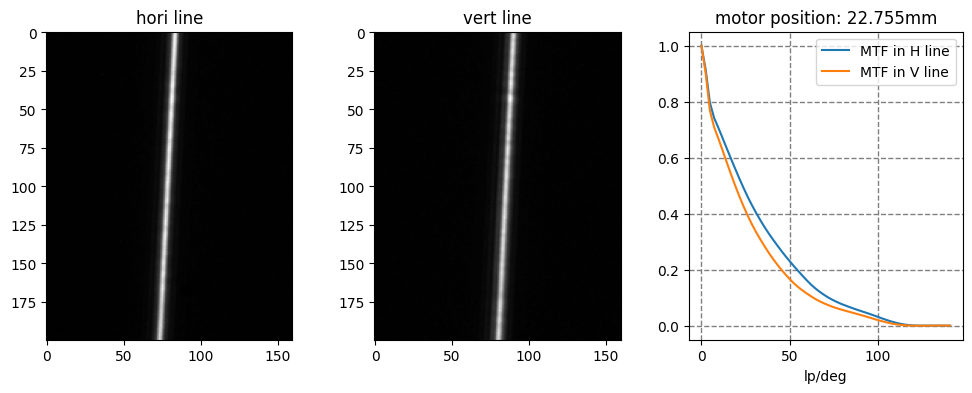

In [36]:
# display ROIs
t_focus_d = []
t_focus_h = []
t_focus_v = []

freq_numbers = 60
freqency = 25
idx = 10

res = thru_focus(idx, freqency, fine_fine_files)
# print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
# t_focus_d.append(float(res["title"][0:-2]))
# t_focus_h.append(res["mtf_h"])
# t_focus_v.append(res["mtf_v"])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(res["roi_image_h"], "gray")
axes[0].set_title("hori line")

axes[1].imshow(res["roi_image_v"], "gray")
axes[1].set_title("vert line")

axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_h"][0:freq_numbers], label='MTF in H line', linestyle='-')
axes[2].plot(res["freq_data"][0:freq_numbers], res["mtf_data_v"][0:freq_numbers], label='MTF in V line', linestyle='-')
axes[2].set_title(f"motor position: {res['title']}")
axes[2].set_xlabel("lp/deg")
axes[2].grid(color='gray', linestyle='--', linewidth=1)
axes[2].legend()

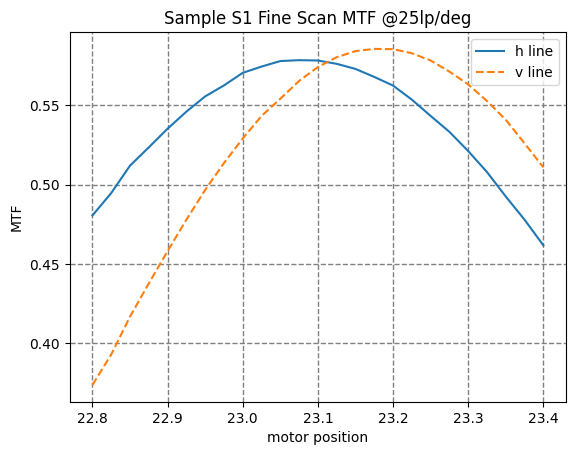

In [15]:
# Sample S1 thru-focus fine scan
t_focus_d = []
t_focus_h = []
t_focus_v = []

freq_numbers = 60
freqency = 25

for idx in range(len(fine_scan_files)):
    res = thru_focus(idx, freqency, fine_scan_files)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    t_focus_d.append(float(res["title"][0:-2]))
    t_focus_h.append(res["mtf_h"])
    t_focus_v.append(res["mtf_v"])

# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d, t_focus_h, label="h line", linestyle="-")
plt.plot(t_focus_d, t_focus_v, label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Sample S1 Fine Scan MTF @25lp/deg")
plt.legend()

In [16]:
# Sample S1 Stats
print(t_focus_h)
print(t_focus_v)
print(t_focus_h[11])
print(t_focus_v[15])

vid_h=30.245
vid_v=38.384

motor_diff = 0.1

[0.4805483280052764, 0.49466453860141124, 0.5119025402011292, 0.5234165883651715, 0.5351704777638989, 0.5458888851009722, 0.5554822657886279, 0.5624011289583225, 0.5703199669397608, 0.5742457084755833, 0.5777230334656276, 0.5782878476749089, 0.5780651539431021, 0.5759823806632798, 0.572770632695426, 0.5677416289099531, 0.5622909351901355, 0.5534501863245183, 0.5431911911093814, 0.5331662626504011, 0.5210714468642161, 0.507850835656676, 0.49245766998023827, 0.4778565006346096, 0.46171293263656654]
[0.373872449713713, 0.39306567796355324, 0.4168817704045002, 0.4377840923563254, 0.4581020535860285, 0.47786480109490975, 0.496633471658922, 0.5135313884299793, 0.5290026963242866, 0.54314940691642, 0.5540265530301539, 0.5652233728243662, 0.5739666885177627, 0.5801378273440362, 0.5839999186470635, 0.585362769930152, 0.585224972467417, 0.5826510766412336, 0.5780541620276777, 0.5710725616414877, 0.5630482299198853, 0.5525683059609865, 0.5407502235458663, 0.5259101794702192, 0.510807340747438]
0.

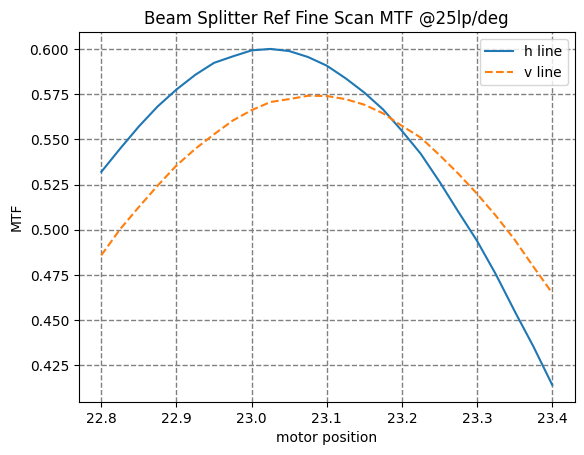

In [17]:
# Beam Splitter Ref
t_focus_d = []
t_focus_h = []
t_focus_v = []

freq_numbers = 60
freqency = 25

for idx in range(len(bs_fine_scan_files)):
    res = thru_focus(idx, freqency, bs_fine_scan_files)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    t_focus_d.append(float(res["title"][0:-2]))
    t_focus_h.append(res["mtf_h"])
    t_focus_v.append(res["mtf_v"])

# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d, t_focus_h, label="h line", linestyle="-")
plt.plot(t_focus_d, t_focus_v, label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Beam Splitter Ref Fine Scan MTF @25lp/deg")
plt.legend()

In [18]:
# Sample Stats
print(t_focus_h)
print(t_focus_v)
print(t_focus_h[9])
print(t_focus_v[11])

vid_h=30.245
vid_v=38.384

motor_diff = 0.05

[0.5320139259833221, 0.5448551827470441, 0.5571646463044486, 0.5682470007376543, 0.5775858370149006, 0.5857095869119006, 0.5923515504331289, 0.5959285640581933, 0.5992478363536278, 0.6000512540018588, 0.5988629682552954, 0.5955760644615407, 0.5907826035528074, 0.5838135408917677, 0.5758698664635878, 0.5665071113582235, 0.554711044272795, 0.5420388769687785, 0.526572947855529, 0.5099581131240607, 0.4937902245155577, 0.4752754003077162, 0.4549004242535752, 0.4353061877141925, 0.41409744827205613]
[0.48586444428085945, 0.5002870325606716, 0.5125856597641496, 0.5244268540532574, 0.5355524835204418, 0.5447302941634526, 0.5528184083102516, 0.5604388318806648, 0.5661651517773248, 0.5706636423733261, 0.5722938307785354, 0.574120936580134, 0.5739847725874302, 0.5722587694502237, 0.5691919185348625, 0.5643635046848041, 0.5574852533928615, 0.5509797280077766, 0.5412932512206541, 0.5310485905097244, 0.5198572496017121, 0.5077223028025948, 0.4944728635532574, 0.47950669485509306, 0.4649244354362271

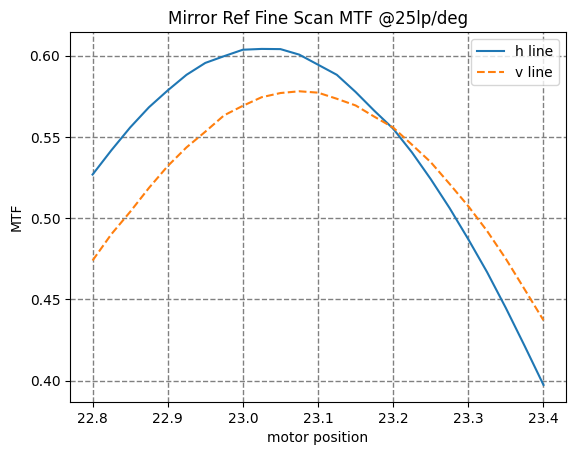

In [19]:
# Mirror Ref Stats
t_focus_d = []
t_focus_h = []
t_focus_v = []

freq_numbers = 60
freqency = 25

for idx in range(len(mirror_fine_scan_files)):
    res = thru_focus(idx, freqency, mirror_fine_scan_files)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    t_focus_d.append(float(res["title"][0:-2]))
    t_focus_h.append(res["mtf_h"])
    t_focus_v.append(res["mtf_v"])

# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d, t_focus_h, label="h line", linestyle="-")
plt.plot(t_focus_d, t_focus_v, label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Mirror Ref Fine Scan MTF @25lp/deg")
plt.legend()

In [20]:
# Mirror Ref Stats
print(t_focus_h)
print(t_focus_v)
print(t_focus_h[9])
print(t_focus_v[11])

vid_h=30.245
vid_v=38.384

motor_diff = 0.05

[0.5268285253103396, 0.541756109091834, 0.5557845778667142, 0.568204871252971, 0.5785760937845605, 0.5881748044818195, 0.5954855202228788, 0.5996363411151165, 0.6036044303023143, 0.6040921397434208, 0.6039752003385738, 0.6005873258073194, 0.5943906528231087, 0.588179342486561, 0.5776197292150209, 0.566011195413789, 0.5550254292339263, 0.5404468405346116, 0.52400812505313, 0.5062601272987485, 0.48699533701608844, 0.4667782731448781, 0.4446868162295981, 0.4213544249764324, 0.39744634361583364]
[0.47395860208623786, 0.49016028719554344, 0.503909233129648, 0.5186031044351967, 0.5320591454841247, 0.5435454586401806, 0.5531787908339135, 0.5632507972165016, 0.5691168376679786, 0.5743945453179649, 0.5769677307742319, 0.578042677764453, 0.5771960390285111, 0.5734430006555353, 0.5693292564659256, 0.562402137452506, 0.5557125348323189, 0.5452013815894454, 0.5344404161340184, 0.5211161105662575, 0.5073527572577393, 0.4921058064949363, 0.47493277218912067, 0.45615496549099843, 0.43720402965335653]


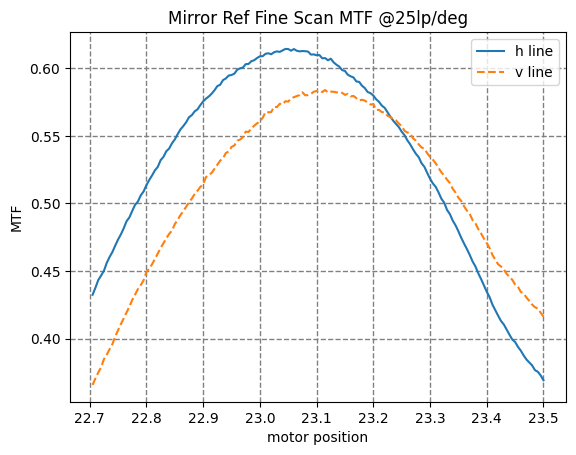

In [37]:
# Mirror Ref Stats
t_focus_d = []
t_focus_h = []
t_focus_v = []

freq_numbers = 60
freqency = 25

for idx in range(len(fine_fine_files)):
    res = thru_focus(idx, freqency, fine_fine_files)
    # print(res["title"][0:-2], res["mtf_h"], res["mtf_v"])
    t_focus_d.append(float(res["title"][0:-2]))
    t_focus_h.append(res["mtf_h"])
    t_focus_v.append(res["mtf_v"])

# plot thrufocus
plt.grid(color="gray", linestyle="--", linewidth=1)
plt.plot(t_focus_d, t_focus_h, label="h line", linestyle="-")
plt.plot(t_focus_d, t_focus_v, label="v line", linestyle="--")
plt.xlabel("motor position")
plt.ylabel("MTF")
plt.title("Mirror Ref Fine Scan MTF @25lp/deg")
plt.legend()

In [43]:
# Mirror Ref Stats
print(t_focus_h)
print(t_focus_v)
print(t_focus_h[71])
print(t_focus_v[81])

vid_h=30.245
vid_v=38.384

motor_diff = 0.005*10
print(motor_diff)

[0.43239106807882033, 0.4375741687690051, 0.4432667965972057, 0.446605872421256, 0.4501164746515842, 0.45603489317303814, 0.46037584179441493, 0.46407248683471686, 0.46889908646668277, 0.4733432142173134, 0.4771529495389426, 0.4817547973583958, 0.48689913468285145, 0.489730673089497, 0.4945678936858367, 0.49903395697155406, 0.5014399895666664, 0.5060176487024579, 0.5088929002865391, 0.5135733315418393, 0.5174439023161767, 0.52082822070119, 0.5245484114779789, 0.5271006080872528, 0.532064002053482, 0.5344948834695088, 0.5386794803393335, 0.5406467723144693, 0.544540382191115, 0.5473980694313657, 0.5513013289165258, 0.5548285749060747, 0.5572869229832841, 0.5601084381177719, 0.563836034465134, 0.5653779613587235, 0.5681663300594244, 0.5696661880866064, 0.5728036956795032, 0.5755510313860599, 0.5776243524702842, 0.579238348583828, 0.5812891091525483, 0.5838231172334912, 0.5868801741010066, 0.5878966013949273, 0.5913176712461442, 0.5925572163737621, 0.5946992629021547, 0.5950954543425205, 